# Demonstration notes

The data consists of material tracking transaction history from start to end of the construction life cycle (i.e, Stages 1-8). It is comprised of 378,618 examples and 14 variables. The following codes have been executed to construct a model (i.e., Multilayer Perceptron) that can predict the possibility of materials (i.e., material_id) being damaged/missing/incorrect (i.e., Yes: Exception = 1; No: Exception = 0) before installation of materials (i.e., Stages 1-4).

# Load data and necessary libraries

In [ ]:
from __future__ import print_function
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('cleaned data 2.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['project_id', 'Stage','timestamp'], inplace=True)

#Filter out transactions that are outside of the analysis focus
test = df[(df['Stage'] != 7) & (df['Stage'] != 8)]
test

,project_id,Stage,timestamp,material_id,material_type,action,prev_value,new_value,app,user_id,user_role,company_id,company_type,company_location
0,154,1,2017-12-08 14:46:00,2.01.L02W05,Window,INSERT,NaN,Not Started,mobile,2,employee,1,unknown,unknown
1,154,1,2017-12-08 14:46:00,2.01.L02W05.C,Window,INSERT,NaN,Not Started,mobile,2,employee,1,unknown,unknown
2,154,1,2017-12-08 14:46:00,2.01.L02W05.D,Window,INSERT,NaN,Not Started,mobile,2,employee,1,unknown,unknown
3,154,1,2017-12-08 14:46:00,2.01.L02W05.E,Window,INSERT,NaN,Not Started,mobile,2,employee,1,unknown,unknown
4,154,1,2017-12-08 14:46:01,2.01.L02W05.F,Window,INSERT,NaN,Not Started,mobile,2,employee,1,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382013,1140,5,2021-08-19 17:23:13,17S-L10-LG-LB05-A,Panels,INSERT,NaN,Finished,web app,1777,other,502,Manufacturer,China
382014,1140,5,2021-08-19 17:23:13,17S-L10-LG-LB06-A,Panels,INSERT,NaN,Finished,web app,1777,other,502,Manufacturer,China
382015,1140,5,2021-08-25 21:17:31,17S-L8-LG-LB11-A,Panels,INSERT,NaN,Finished,web app,1843,other,502,Manufacturer,China
382016,1140,5,2021-08-25 21:17:31,17S-L9-LG-LB11-A,Panels,INSERT,NaN,Finished,web app,1843,other,502,Manufacturer,China


# Data manipulation

In [ ]:
#Create new variables
test['Manufactured'] = [1 if x == 2 else 0 for x in test['Stage']] #Whether materials undergone manufacturing
test['Shipped'] = [1 if x == 3 else 0 for x in test['Stage']] #Whether materials undergone shipping
test['Installed'] = [1 if x == 4 else 0 for x in test['Stage']] #Whether materials undergone installation
test['Overseas company'] = [1 if x == 'China' else 0 for x in test['company_location']] #Whether materials came from overseas
test['Exception'] = [1 if x == 6 else 0 for x in test['Stage']] #Label: whether material was damaged

#Create new dataframe with the new variables for each material_id
new = test.groupby(['material_id','material_type'],as_index=False).agg({'Manufactured':'max','Shipped':'max','Installed':'max','Overseas company':'max', 'Exception':'max'})

In [ ]:
#Create new variable: number of suppliers
cn1 = test[(test['Stage'] == 1) | (test['Stage'] == 2) | (test['Stage'] == 3)]
cn = (cn1.groupby(['material_id']).apply(lambda x: len(x['company_id'].unique()))).reset_index()
cn = cn.apply(pd.Series)

#Create new variable: days in manufacturing
stage2 = test[(test['Stage'] == 2)]
manf = (stage2.groupby(['material_id']).apply(lambda x: (x['timestamp'].iloc[-1] - x['timestamp'].iloc[0]).days+1)).reset_index()
manf = manf.apply(pd.Series)

#Create new variable: days in shipping
stage3 = test[(test['Stage'] == 3)]
sh = (stage3.groupby(['material_id']).apply(lambda x: (x['timestamp'].iloc[-1] - x['timestamp'].iloc[0]).days+1)).reset_index()
sh = sh.apply(pd.Series)

#Rename columns for each new variable
sh = sh.rename(columns={0: 'Days in shipping'})
manf = manf.rename(columns={0: 'Days in manufacturing'})
cn = cn.rename(columns={0: 'No of suppliers'})

In [ ]:
#Merge all new variables together with the new dataframe
merge1 = pd.merge(left=new, right=manf, how='left', left_on='material_id', right_on='material_id')
merge2 = pd.merge(left=merge1, right=sh, how='left', left_on='material_id', right_on='material_id')
merge3 = pd.merge(left=merge2, right=cn, how='left', left_on='material_id', right_on='material_id')
merge3.fillna('0', inplace=True)
merge3.head()

,material_id,material_type,Manufactured,Shipped,Installed,Overseas company,Exception,Days in manufacturing,Days in shipping,No of suppliers
0,'EN2-L10-115-HF-VFa,CW Panels,1,1,1,1,0,1.0,1.0,2.0
1,'EN2-L16-S036-HF-VFb-Ba,CW Panels,1,1,1,1,0,1.0,57.0,2.0
2,00.04-C.1,Joinery,0,0,0,0,0,0,0,1.0
3,00.05-S.1,Joinery,0,0,0,0,0,0,0,1.0
4,00.05-S.2,Joinery,0,0,0,0,0,0,0,1.0


In [ ]:
#One-hot encode material type for each material_id and combine with other variables to create final dataset
dummies = pd.get_dummies(merge3.material_type)  
merged = pd.concat([merge3,dummies],axis=1)  
final = merged.drop(['material_type'], axis=1)
final

,material_id,Manufactured,Shipped,Installed,Overseas company,Days in manufacturing,Days in shipping,No of suppliers,Aluminium Cladding,Aluminium Plate,...,Trucks,WW Panels,WW Sash,WW Sliding-door Frame,WW Subframe,Window,Window Panel,Window Sash,Window Wall,Exception
0,'EN2-L10-115-HF-VFa,1,1,1,1,1.0,1.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,'EN2-L16-S036-HF-VFb-Ba,1,1,1,1,1.0,57.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,00.04-C.1,0,0,0,0,0,0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00.05-S.1,0,0,0,0,0,0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00.05-S.2,0,0,0,0,0,0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93339,Φ8(361#),1,1,0,1,1.0,26.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
93340,∅12mm(75#),0,1,0,1,0,72.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
93341,十字槽盘头自攻钉STAINLESS STEEL SCREW,0,1,0,1,0,8.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
93342,（L=1200mm）(389#),1,1,0,1,1.0,1.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data pre-processing

In [ ]:
#Manually balance dataset
final.set_index('material_id', inplace=True)
f1 = final[final['Exception'] == 0]
f1 = f1.sample(n=5000)
f2 = final[final['Exception'] == 1]
final = pd.concat([f1, f2])
final

,Manufactured,Shipped,Installed,Overseas company,Days in manufacturing,Days in shipping,No of suppliers,Aluminium Cladding,Aluminium Plate,Assembly,Bathroom and Kitchen Supplies,Bill of Lading No.,Brackets,Bullet Feature,CNC Variation,CW Panels,Cast-ins,Containers,Crates,Curtain Wall,Delivery,Door Frame,Facade,Frame For Curtain Wall,GRC,Gutter Sleeves,Horizontal Sunshape,Joinery,Loose Items,Miscellaneous,Pallet,Panels,Paper Box,Pelmet,Perforated aluminium panel,Production & Logistics,Replacement Glass,Rooms,Shipment #,Shipping Container,Sill,Smoke Flashing,Steel,Stillage,Sub-Components,Subframes,Subsill,Trucks,WW Panels,WW Sash,WW Sliding-door Frame,WW Subframe,Window,Window Panel,Window Sash,Window Wall,Exception
material_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
L8-CI086,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17S-CW-L09-P46,1,1,1,1,6.0,18.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32102,0,1,0,0,0,1.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
HF-L15-S0129-FIN,0,1,0,1,0,20.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A.01.04.KT04.F09A-BC,0,1,0,1,0,124.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W08-041,0,1,1,0,0,17.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
W08-045,0,1,1,0,0,30.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
W09-010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Assign label
label_col = 'Exception'

#Split dataset for training and validation
train_size, valid_size, test_size = (0.7, 0.3, 0.0)
att_train, att_valid = train_test_split(final, 
                                      test_size=valid_size, 
                                      random_state=0)

y_train = att_train[[label_col]]
x_train = att_train.drop(label_col, axis=1)
y_valid = att_valid[[label_col]]
x_valid = att_valid.drop(label_col, axis=1)

print('Result 1: Sizes of training and validation sets\n')
print('Size of training set: ', len(x_train))
print('Size of validation set: ', len(x_valid))

Result 1: Sizes of training and validation sets

Size of training set:  5575
Size of validation set:  2390


In [ ]:
#Sample counts of each class (validation set)
count1 = y_valid[y_valid['Exception'] == 1].count()
count2 = y_valid[y_valid['Exception'] == 0].count()
print('Result 2: Samples per class\n')
print('Count of "Exception = Yes": ', count1)
print('Count of "Exception = No": ', count2)

Result 2: Samples per class

Count of "Exception = Yes":  Exception    895
dtype: int64
Count of "Exception = No":  Exception    1495
dtype: int64


In [ ]:
#Sample counts of each class (training set)
count1 = y_train[y_train['Exception'] == 1].count()
count2 = y_train[y_train['Exception'] == 0].count()
print('Result 2: Samples per class\n')
print('Count of "Exception = Yes": ', count1)
print('Count of "Exception = No": ', count2)

Result 2: Samples per class

Count of "Exception = Yes":  Exception    2070
dtype: int64
Count of "Exception = No":  Exception    3505
dtype: int64


In [ ]:
#Normalisation of training and validation datasets
scale = MinMaxScaler(feature_range=(0, 1), copy=True).fit(x_train)
x_train = pd.DataFrame(scale.transform(x_train), 
                            columns = x_train.columns, index = x_train.index)
x_valid = pd.DataFrame(scale.transform(x_valid), 
                            columns = x_valid.columns, index = x_valid.index)

print('Result 4: Min and max values in training and validation sets\n')
print('X train min =', round(x_train.min().min(),4), '; max =', round(x_train.max().max(), 4))
print('X valid min =', round(x_valid.min().min(),4), '; max =', round(x_valid.max().max(), 4))

Result 4: Min and max values in training and validation sets

X train min = 0.0 ; max = 1.0
X valid min = 0.0 ; max = 1.0


# Modelling

In [ ]:
pip install -U keras-tuner

In [ ]:
#Install necessary libraries
import tensorflow as tf
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop
from keras_tuner.tuners import RandomSearch

In [ ]:
#Reshape inputs
arr_x_train = np.array(x_train)
arr_y_train = np.array(y_train)
arr_x_valid = np.array(x_valid)
arr_y_valid = np.array(y_valid)

print('Result 5: Dataset shapes\n')
print('Training shape:', x_train.shape)
print('Training samples: ', x_train.shape[0])
print('Validation samples: ', x_valid.shape[0])

Result 5: Dataset shapes

Training shape: (5575, 56)
Training samples:  5575
Validation samples:  2390


In [ ]:
#Define optimisation model to tune parameters
def build_model(hp):
    model = Sequential()
    model.add(Flatten())
              
    # Tune the number of layers
    for i in range(hp.Int("num_layers", 2, 10)):
        model.add(
            Dense(
                # Tune number of units and activation functions separately
                units=hp.Int(f"units_{i}", min_value=30, max_value=600, step=30),
                activation=hp.Choice(f"activation_{i}", ["relu", "tanh"]),
                kernel_initializer=hp.Choice(f"kin_{i}", ["glorot_normal", "he_normal","random_normal"]),
                kernel_regularizer=hp.Choice(f"kreg_{i}", ["L1", "L2", "L1L2"]),
                bias_regularizer=hp.Choice(f"breg_{i}", ["L1", "L2", "L1L2"]),
            )
        )
        #Tune if dropout will be used or not
        if hp.Boolean("dropout"):
          model.add(Dropout(rate=0.2))

    model.add(Dense(1, activation="sigmoid"))

    #Tune optimizer and optimizer learning rate value
    hp_lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    hp_optimizer=hp.Choice('optimizer', values=['adam', 'nadam', 'SGD', 'RMSprop'])
    if hp_optimizer == 'SGD':
      optim = SGD(learning_rate=hp_lr)
    elif hp_optimizer == 'RMSprop':
      optim = RMSprop(learning_rate=hp_lr)
    elif hp_optimizer == 'adam':
      optim = Adam(learning_rate=hp_lr)
    elif hp_optimizer == 'nadam':
      optim = Nadam(learning_rate=hp_lr)
    else:
      raise

    model.compile(
        optimizer=optim,
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
#Embed defined model in search operation
tuner = RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=3,
    seed=0,
    overwrite=True,
    directory="my_dir",
    project_name="attrition",
)

In [ ]:
#Define callback arguments
from tensorflow.keras.callbacks import EarlyStopping

keras_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, verbose=0)
]

In [ ]:
#Fit model to find best parameters
tuner.search(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid),callbacks=keras_callbacks)

Trial 5 Complete [00h 01m 55s]
val_accuracy: 0.8737796545028687

Best val_accuracy So Far: 0.8737796545028687
Total elapsed time: 00h 10m 45s


In [ ]:
#Produce hyperparameters summary of best model found
print('Result 5: Hyperparameters summary for best model found\n')
tuner.results_summary(1)

Result 5: Hyperparameters summary for best model found

Results summary
Results in my_dir/attrition
Showing 1 best trials
Trial summary
Hyperparameters:
num_layers: 5
units_0: 480
activation_0: relu
kin_0: he_normal
kreg_0: L2
breg_0: L2
dropout: True
units_1: 120
activation_1: tanh
kin_1: random_normal
kreg_1: L2
breg_1: L1L2
lr: 0.00013155025095514265
optimizer: nadam
units_2: 150
activation_2: tanh
kin_2: he_normal
kreg_2: L1L2
breg_2: L2
units_3: 540
activation_3: tanh
kin_3: glorot_normal
kreg_3: L2
breg_3: L2
units_4: 60
activation_4: relu
kin_4: glorot_normal
kreg_4: L2
breg_4: L2
units_5: 90
activation_5: relu
kin_5: he_normal
kreg_5: L2
breg_5: L1
units_6: 510
activation_6: tanh
kin_6: he_normal
kreg_6: L2
breg_6: L1
units_7: 390
activation_7: tanh
kin_7: glorot_normal
kreg_7: L2
breg_7: L1
units_8: 210
activation_8: tanh
kin_8: glorot_normal
kreg_8: L2
breg_8: L2
units_9: 270
activation_9: relu
kin_9: he_normal
kreg_9: L1L2
breg_9: L1L2
Score: 0.8737796545028687


In [ ]:
#View model architecture
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.build(input_shape=(None,56))
print('Table 7: Architecture of model with best hyperparameters\n')
best_model.summary()

Table 7: Architecture of model with best hyperparameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 56)                0         
                                                                 
 dense (Dense)               (None, 480)               27360     
                                                                 
 dropout (Dropout)           (None, 480)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               57720     
                                                                 
 dropout_1 (Dropout)         (None, 120)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               18150     
                                                                

In [ ]:
# Get the top hyperparameters
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hyperparameters
model = build_model(best_hps[0])

In [ ]:
#Retrain the model using the best hyperparameters
history = model.fit(arr_x_train, arr_y_train,
    batch_size=52,
    epochs=100,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

In [ ]:
#Evaluating performance of the model
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Accuracy: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val Accuracy: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train Accuracy:  0.889 , Train Loss:  0.3328
Val Accuracy:  0.8766 , Val Loss:  0.361


In [ ]:
#Visualising model performance
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]
    
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()
    
    return

Figure 1: Graphs of training vs validation loss and accuracy



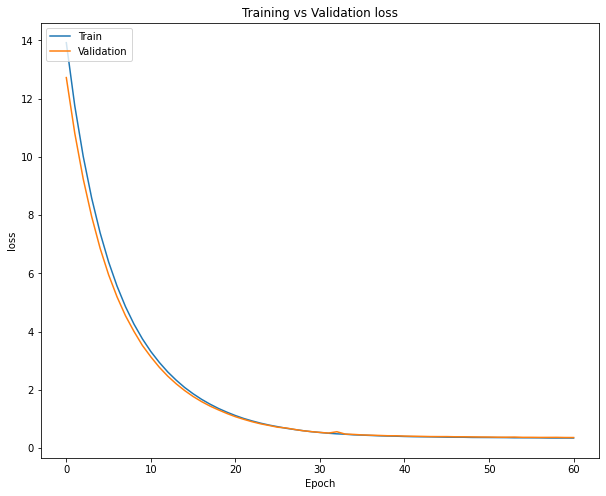

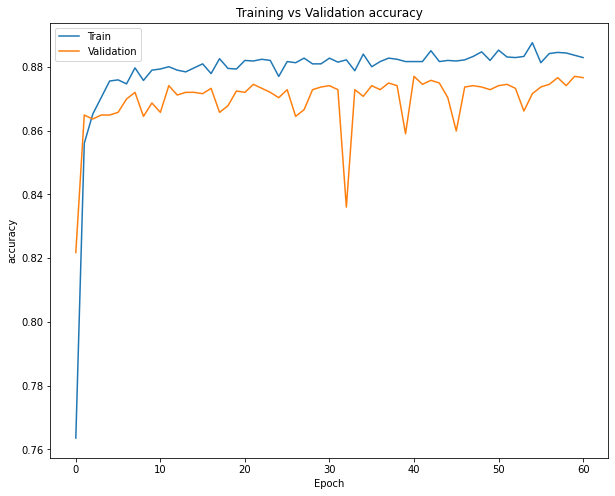

In [ ]:
#Plot training history
hist = pd.DataFrame(history.history)
print('Figure 1: Graphs of training vs validation loss and accuracy\n')
plot_hist(hist, xsize=10, ysize=8)

In [ ]:
test = model.predict(x_valid)

In [ ]:
#Evaluating model performance (threshold = 70%) through classification report
from sklearn.metrics import classification_report
predicted_categories = [1 * (x[0]>=0.7) for x in test]
print('Table 8: Classification Report\n')
print(classification_report(y_valid, predicted_categories))

Table 8: Classification Report

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1495
           1       0.88      0.71      0.78       895

    accuracy                           0.85      2390
   macro avg       0.86      0.82      0.84      2390
weighted avg       0.86      0.85      0.85      2390

